# Mini Challenge: Deep Learning for Images and Signals
- Name: Nils Fahrni
- Submission Date: t.b.d.

## How does the performance of a U-Net semantic segmentation model differ between scenes of city streets and non-city streets in the BDD100K dataset?

## Package Usage

In [1]:
#%env WANDB_SILENT=True
%env "WANDB_NOTEBOOK_NAME" "dlbs"

import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import wandb
import random

env: "WANDB_NOTEBOOK_NAME"="dlbs"


In [2]:
RANDOM_SEED = 1337

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Dataset
Berkeley Deep Drive Dataset: https://arxiv.org/abs/1805.04687

In [3]:
import os

BASE_DATA_PATH = os.path.join('data', 'bdd100k', 'images', '10k', 'train')
BASE_LABELS_PATH = os.path.join('data', 'bdd100k', 'labels', 'sem_seg', 'masks', 'train')

### Exploration

[Become one with the data](https://karpathy.github.io/2019/04/25/recipe/#:~:text=1.%20Become%20one%20with%20the%20data)

#### Metrics

In [4]:
from data.utils import custom_split_dataset_with_det, ConvertToLongTensor
from data import BDD100KDataset
import torch
from torchvision import transforms


import hydra
from hydra import compose, initialize

with initialize(version_base=None, config_path="./configs"):
    cfg = compose(config_name="config")

dataset_splits = custom_split_dataset_with_det(
    base_data_path=cfg.dataset.images_dir,
    base_labels_path=cfg.dataset.labels_dir,
    det_train_path=cfg.dataset.det_train_path,
    det_val_path=cfg.dataset.det_val_path,
    test_size=cfg.dataset.test_size,
    random_state=cfg.seed
)

train_dataset = BDD100KDataset(
    images_dir=dataset_splits['train']['data_folder'],
    labels_dir=dataset_splits['train']['labels_folder'],
    filenames=dataset_splits['train']['image_filenames'],
    transform=hydra.utils.instantiate(cfg.dataset.transform),
    target_transform=hydra.utils.instantiate(cfg.dataset.target_transform),
    scene_info=dataset_splits['train']['scene_map']
)

train_dataset_full = BDD100KDataset(
    images_dir=dataset_splits['train']['data_folder'],
    labels_dir=dataset_splits['train']['labels_folder'],
    filenames=dataset_splits['train']['image_filenames'],
    transform=hydra.utils.instantiate(cfg.dataset.transform),
    target_transform=transforms.Compose([
        transforms.Resize(128),
        ConvertToLongTensor(),
    ]),
    scene_info=dataset_splits['train']['scene_map']
)

val_dataset = BDD100KDataset(
    images_dir=dataset_splits['val']['data_folder'],
    labels_dir=dataset_splits['val']['labels_folder'],
    filenames=dataset_splits['val']['image_filenames'],
    transform=hydra.utils.instantiate(cfg.dataset.transform),
    target_transform=hydra.utils.instantiate(cfg.dataset.target_transform),
    scene_info=dataset_splits['val']['scene_map']
)


--- Split Sizes ---
- Train Images: 2518
- Val Images: 454
- Test Images: 454



In [8]:
torch.unique(train_dataset[0][1])

tensor([  0,   1,   2,   3,   4, 255])

In [5]:
import torch
from torchvision import transforms
from data.utils import calculate_normalization_stats

mean, std = calculate_normalization_stats(dataset_splits['train']['image_filenames'], BASE_DATA_PATH)

print('--- Normalization Metrics ---')
print(f'- Mean: {mean}\n- Standard Deviation: {std}')

--- Normalization Metrics ---
- Mean: tensor([0.3652, 0.3999, 0.4053])
- Standard Deviation: tensor([0.2527, 0.2645, 0.2755])


#### Looking at some samples

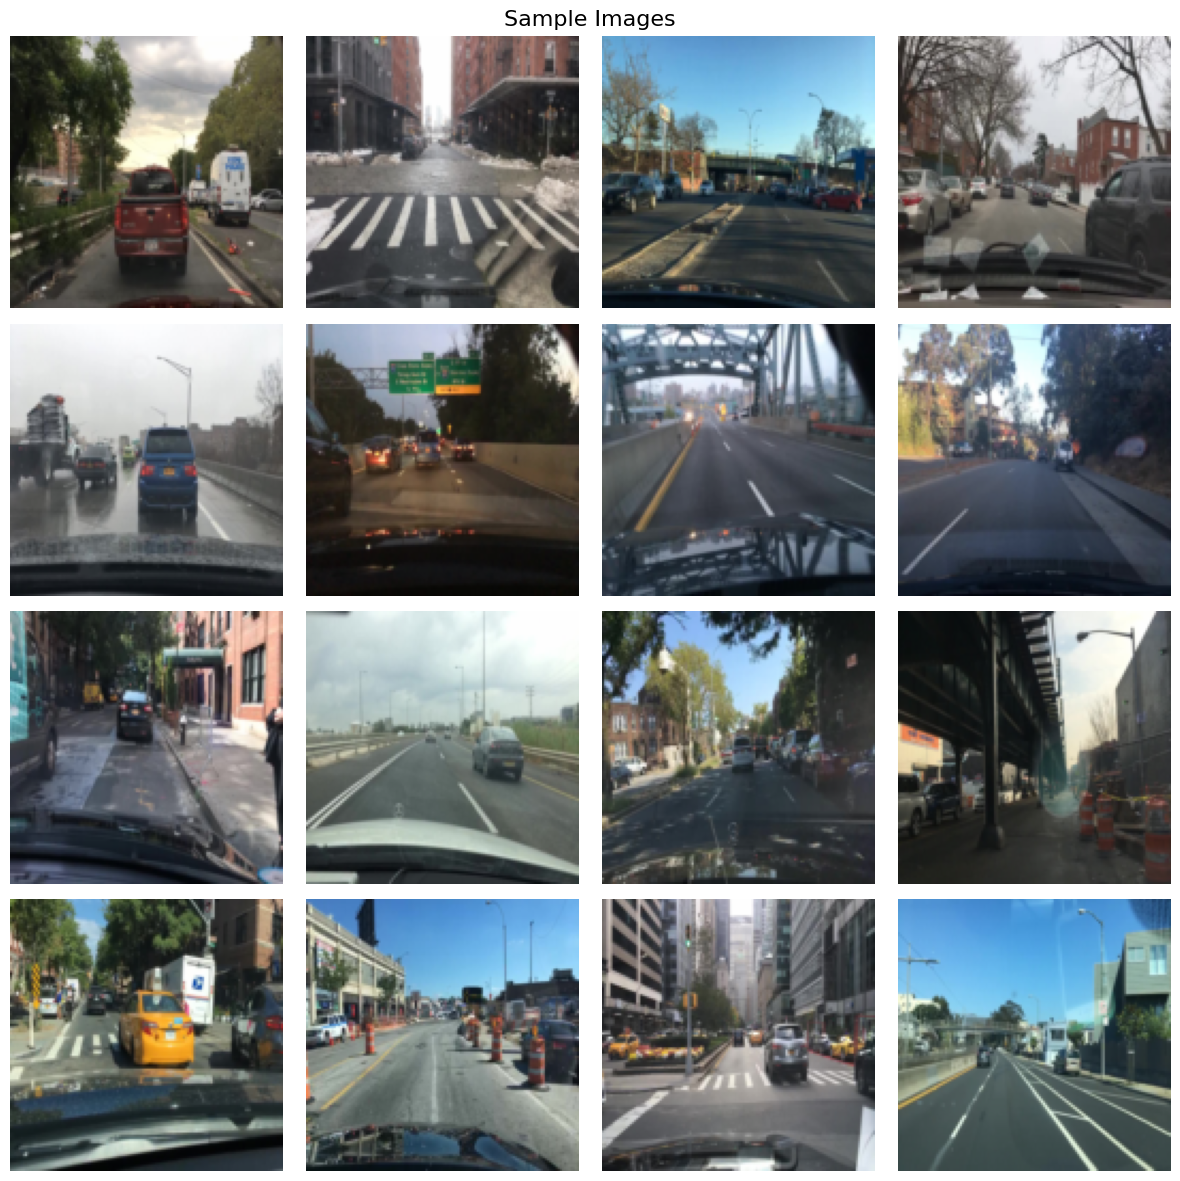

In [16]:
from data.utils import unnormalize

def show_image_grid(dataset, mean=None, std=None, grid_size=(4, 4)):
    """
    Display a grid of images from the dataset.
    Args:
        dataset (Dataset): The dataset object.
        mean (list): Mean values used for normalization.
        std (list): Standard deviation values used for normalization.
        grid_size (tuple): Dimensions of the grid (rows, cols).
    """
    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    
    for i, ax in enumerate(axes.flat):
        if i >= len(dataset):
            break
        image, *rest = dataset[i]  # `*rest` captures additional outputs like label or scene
        
        # Unnormalize the image if mean and std are both provided
        if mean is not None and std is not None:
            image = unnormalize(image, mean, std)
            
        image = image.permute(1, 2, 0).cpu().numpy()

        # Display the image
        ax.imshow(image)
        ax.axis('off')
    
    # give the plot a title
    plt.suptitle('Sample Images', size=16)
    
    plt.tight_layout()
    plt.show()

show_image_grid(val_dataset, mean, std)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3949602..2.5122724].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2466406..2.5122724].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4310309..2.3259747].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3801281..2.3259747].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2763045..2.5122724].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4291662..2.5122724].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.431030

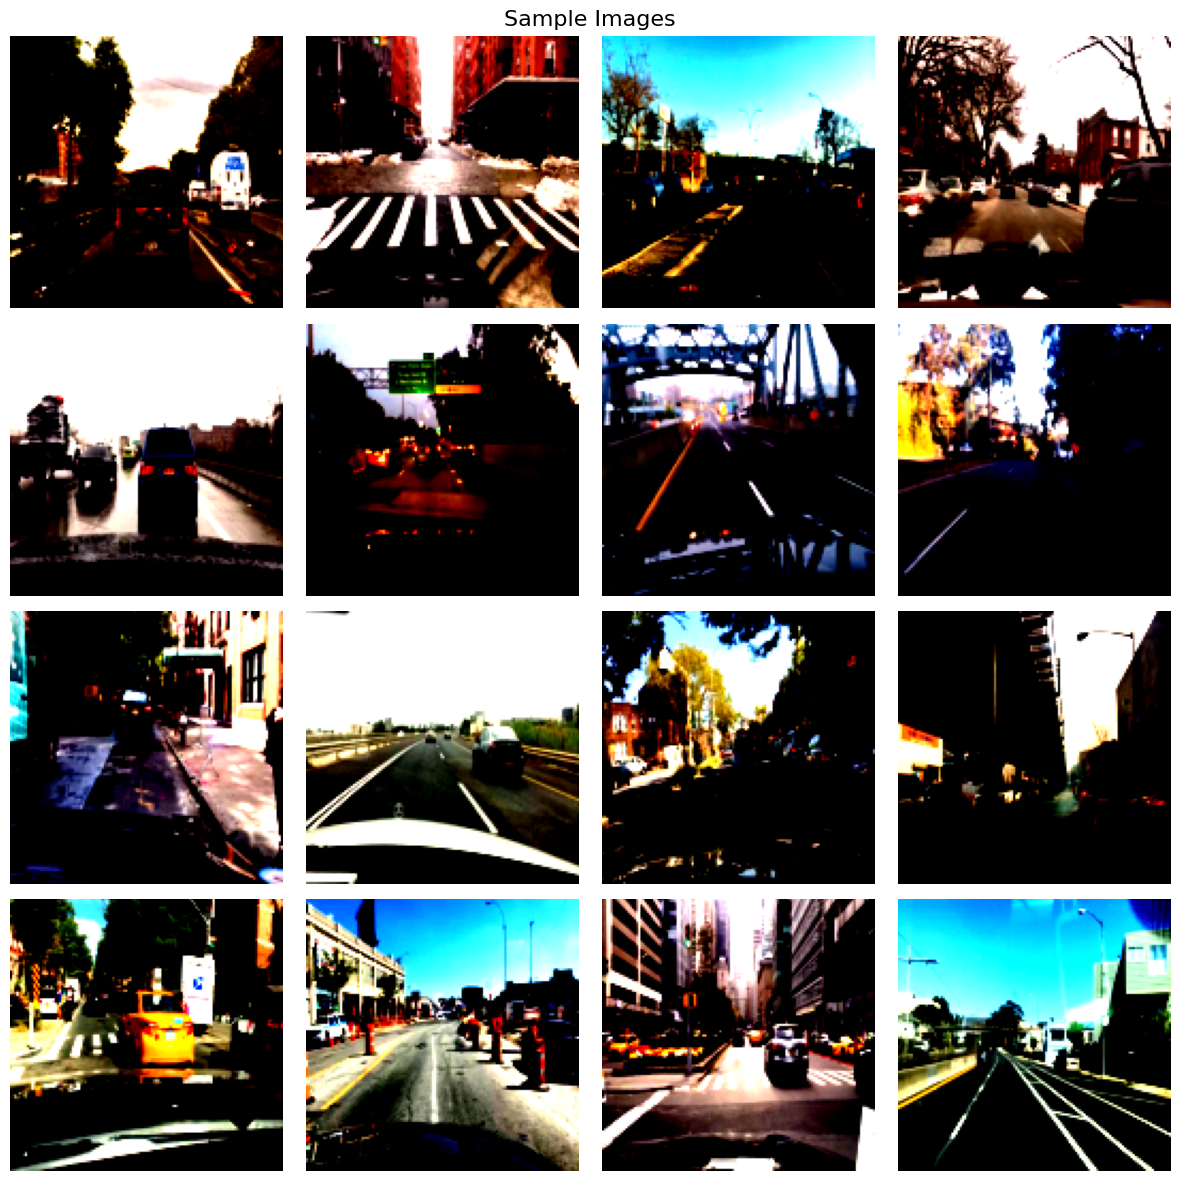

In [33]:
show_image_grid(val_dataset)

#### Spatial Heatmap

https://doc.bdd100k.com/format.html#semantic-segmentation

In [6]:
class_dict = {
    0: "road",
    1: "sidewalk",
    2: "building",
    3: "wall",
    4: "fence",
    5: "pole",
    6: "traffic light",
    7: "traffic sign",
    8: "vegetation",
    9: "terrain",
    10: "sky",
    11: "person",
    12: "rider",
    13: "car",
    14: "truck",
    15: "bus",
    16: "train",
    17: "motorcycle",
    18: "bicycle"
}

Processing Classes:   0%|          | 0/19 [00:00<?, ?it/s]

Processing Classes: 100%|██████████| 19/19 [01:23<00:00,  4.40s/it]


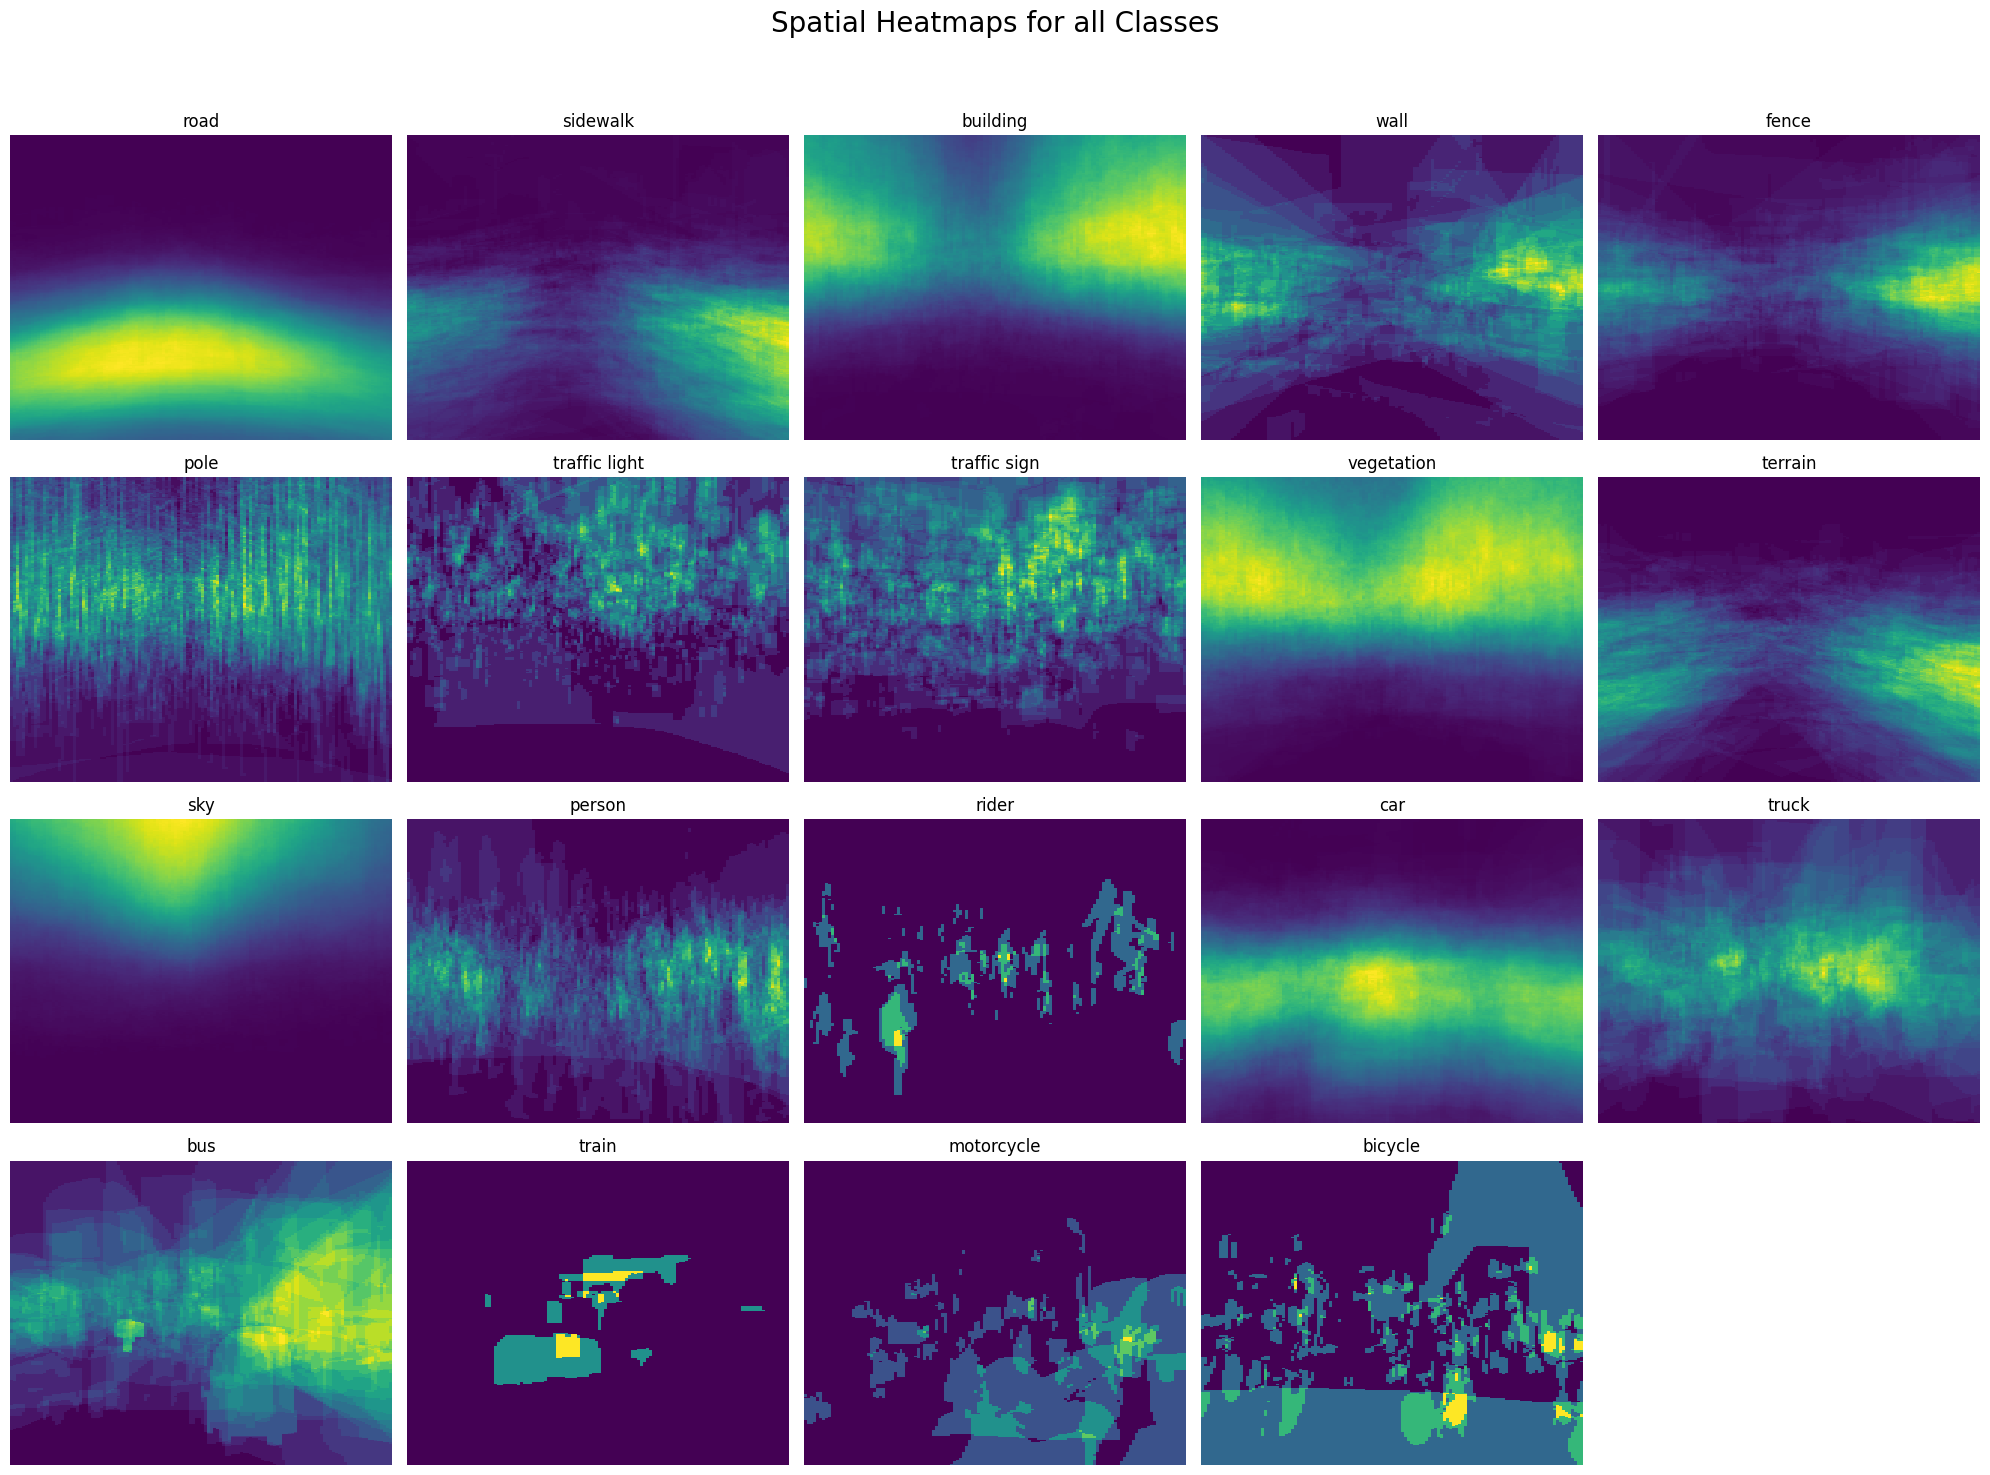

In [19]:

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from tqdm import tqdm

label_folder = BASE_LABELS_PATH

target_width, target_height = 128, 228
N_SAMPLES = 1000

heatmaps = {class_id: np.zeros((target_height, target_width), dtype=np.float32) for class_id in class_dict.keys()}

for class_id, class_name in tqdm(class_dict.items(), desc="Processing Classes"):
    all_files = [f for f in os.listdir(label_folder) if f.endswith('.png')]
    sampled_files = random.sample(all_files, min(N_SAMPLES, len(all_files)))
    
    for file in tqdm(sampled_files, desc=f"Sampling {class_name}", leave=False):
        label_path = os.path.join(label_folder, file)
        with Image.open(label_path) as img:
            label = np.array(img)
            
            label_resized = np.array(Image.fromarray(label).resize((target_width, target_height), Image.NEAREST))

            mask = (label_resized == class_id)
            heatmaps[class_id] += mask.astype(np.float32)

    heatmaps[class_id] /= len(sampled_files)

fig, axs = plt.subplots(4, 5, figsize=(20, 15))
fig.suptitle("Spatial Heatmaps for all Classes", fontsize=20)

for class_id, class_name in class_dict.items():
    ax = axs[class_id // 5, class_id % 5]
    sns.heatmap(heatmaps[class_id], ax=ax, cmap="viridis", cbar=False)
    ax.set_title(class_name)
    ax.axis('off')

for i in range(len(class_dict), 4 * 5):
    fig.delaxes(axs[i // 5, i % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Observations**
- Train, Rider, Motorcycle and bicycle seem to be rather underrepresented since these objects' shapes are still clearly visible and don't have a high overlap

#### Class Distribution

Processing Dataset: 100%|██████████| 2518/2518 [00:36<00:00, 69.19it/s]


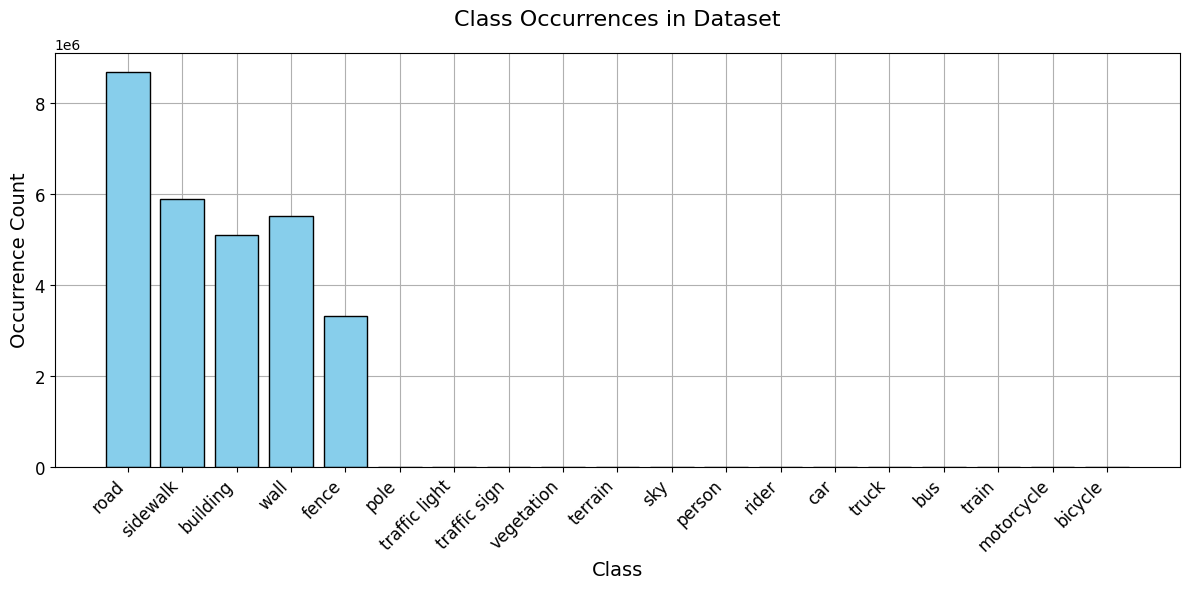

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming train_dataset is initialized as described
num_classes = len(class_dict)
class_names = list(class_dict.values())

# Initialize a counter for each class
class_occurrence_count = np.zeros(num_classes, dtype=np.int32)

# Iterate over the train dataset to extract masks and count classes
for i in tqdm(range(len(train_dataset)), desc="Processing Dataset"):
    _, mask, _ = train_dataset[i]  # Retrieve the image, mask, and scene label (mask is at index 1)
    mask = mask.numpy()  # Convert mask tensor to a numpy array if necessary

    # Count occurrences of each class in the mask
    unique, counts = np.unique(mask, return_counts=True)
    for class_id, count in zip(unique, counts):
        if class_id < num_classes:  # Ensure the class ID is within valid range
            class_occurrence_count[class_id] += count

# Plot a bar chart of occurrences
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_occurrence_count, color="skyblue", edgecolor="black", zorder=2)
plt.grid(True, zorder=1)
# Add labels and title
plt.title("Class Occurrences in Dataset", fontsize=16, pad=20)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Occurrence Count", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


Processing Dataset: 100%|██████████| 2518/2518 [00:35<00:00, 70.80it/s]


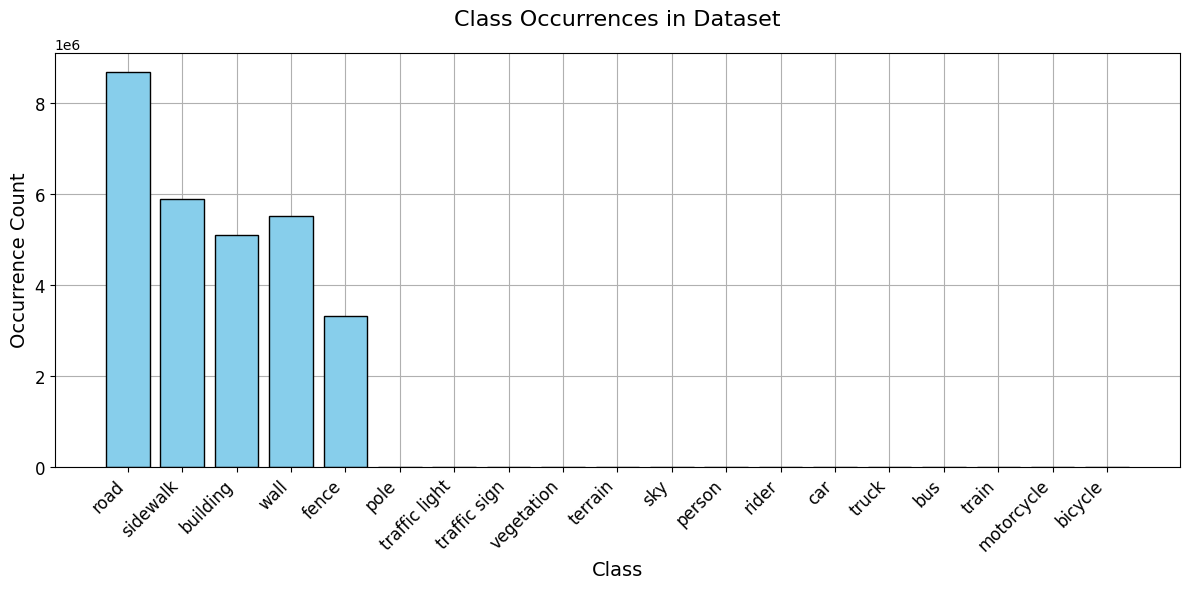

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_dataset is initialized as described
num_classes = len(class_dict)
class_names = list(class_dict.values())

# Initialize a counter for each class
class_occurrence_count = np.zeros(num_classes, dtype=np.int32)

# Iterate over the train dataset to extract masks and count classes
for i in tqdm(range(len(train_dataset_full)), desc="Processing Dataset"):
    _, mask, _ = train_dataset[i]  # Retrieve the image, mask, and scene label (mask is at index 1)
    mask = mask.numpy()  # Convert mask tensor to a numpy array if necessary

    # Count occurrences of each class in the mask
    unique, counts = np.unique(mask, return_counts=True)
    for class_id, count in zip(unique, counts):
        if class_id < num_classes:  # Ensure the class ID is within valid range
            class_occurrence_count[class_id] += count

# Plot a bar chart of occurrences
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_occurrence_count, color="skyblue", edgecolor="black", zorder=2)
plt.grid(True, zorder=1)
# Add labels and title
plt.title("Class Occurrences in Dataset", fontsize=16, pad=20)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Occurrence Count", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


In [25]:
selected_classes = [0,2,8,10,13]
for cls in selected_classes:
    print(class_dict.get(cls))

road
building
vegetation
sky
car


#### Co-Occurence

Processing Masks in data\bdd100k\labels\sem_seg\masks\train: 100%|██████████| 7000/7000 [02:08<00:00, 54.52it/s]


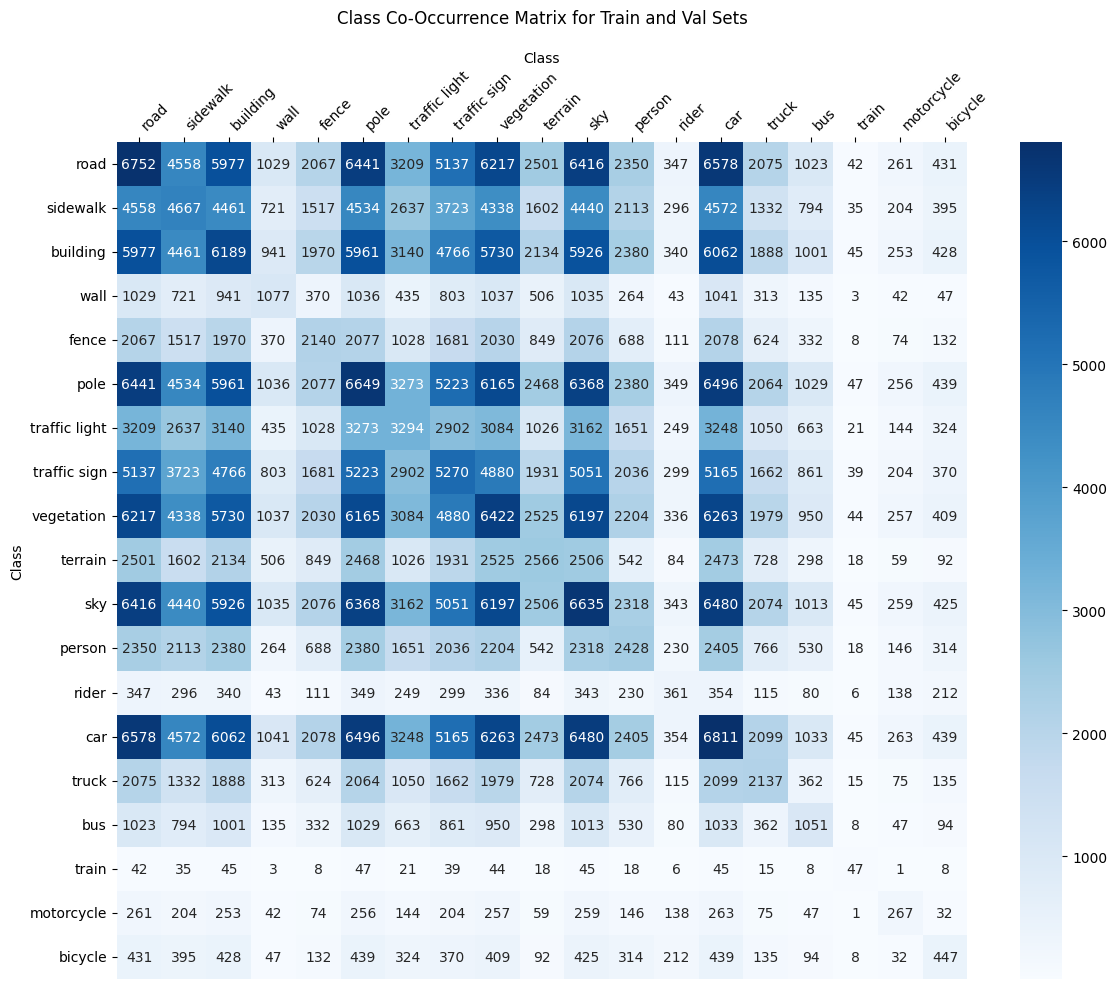

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

label_folders = [BASE_LABELS_PATH]
num_classes = len(class_dict)
class_names = list(class_dict.values())

co_occurrence_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

for label_folder in label_folders:
    all_files = [f for f in os.listdir(label_folder) if f.endswith('.png')]
    
    for file in tqdm(all_files, desc=f"Processing Masks in {label_folder}"):
        label_path = os.path.join(label_folder, file)
        with Image.open(label_path) as img:
            label = np.array(img)

            unique_classes = np.unique(label)

            for i in range(len(unique_classes)):
                for j in range(i, len(unique_classes)):
                    class_i = unique_classes[i]
                    class_j = unique_classes[j]
                    if class_i < num_classes and class_j < num_classes:
                        co_occurrence_matrix[class_i, class_j] += 1
                        if class_i != class_j:
                            co_occurrence_matrix[class_j, class_i] += 1

plt.figure(figsize=(12, 10))
ax = sns.heatmap(co_occurrence_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Class Co-Occurrence Matrix for Train and Val Sets", pad=20)
plt.xlabel("Class")
plt.ylabel("Class")

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

plt.xticks(rotation=45, ha="left")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Training and Evaluation Skeleton

[Set up the end-to-end training/evaluation skeleton + get dumb baselines](https://karpathy.github.io/2019/04/25/recipe/#:~:text=Set%20up%20the%20end%2Dto%2Dend%20training/evaluation%20skeleton%20%2B%20get%20dumb%20baselines)

In [7]:
import torch
import torch.nn as nn
from torcheval.metrics import MulticlassAccuracy

RANDOM_SEED = 1337

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using mps device


#### Data Loading & Splitting

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import torch

from data import BDD100KDataset, custom_split_dataset_with_det, check_dataset_overlap

DET_TRAIN_PATH = './data/bdd100k/labels/det_20/det_train.json'
DET_VAL_PATH = './data/bdd100k/labels/det_20/det_val.json'

split_data = custom_split_dataset_with_det(base_data_path=BASE_DATA_PATH, 
                                           base_labels_path=BASE_LABELS_PATH, 
                                           det_train_path=DET_TRAIN_PATH, 
                                           det_val_path=DET_VAL_PATH)

check_dataset_overlap(
    split_data['train']['image_filenames'],
    split_data['val']['image_filenames'],
    split_data['test']['image_filenames']
)

image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # Apply normalization
])

label_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.long)),
])

train_dataset = BDD100KDataset(
    images_dir=split_data['train']['data_folder'],
    labels_dir=split_data['train']['labels_folder'],
    filenames=split_data['train']['image_filenames'],
    transform=image_transform,
    target_transform=label_transform,
    scene_info=split_data['train']['scene_map']
)

val_dataset = BDD100KDataset(
    images_dir=split_data['val']['data_folder'],
    labels_dir=split_data['val']['labels_folder'],
    filenames=split_data['val']['image_filenames'],
    transform=image_transform,
    target_transform=label_transform,
    scene_info=split_data['val']['scene_map']
)

test_dataset = BDD100KDataset(
    images_dir=split_data['test']['data_folder'],
    labels_dir=split_data['test']['labels_folder'],
    filenames=split_data['test']['image_filenames'],
    transform=image_transform,
    target_transform=label_transform,
    scene_info=split_data['test']['scene_map']
)


--- Split Sizes ---
- Train Images: 2518
- Val Images: 454
- Test Images: 454

--- Overlap Report ---
✔️ No overlap detected between train and validation sets.
✔️ No overlap detected between train and test sets.
✔️ No overlap detected between validation and test sets.



In [9]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import trange

def map_class_names_and_order(class_distribution, class_dict):
    ordered_classes = sorted(class_dict.keys())  # Ensure consistent class order
    class_names = [class_dict[class_id] for class_id in ordered_classes if class_id in class_distribution]
    proportions = [class_distribution[class_id] for class_id in ordered_classes if class_id in class_distribution]
    return class_names, proportions

def plot_class_distribution(class_distribution, title, class_dict):
    class_names, proportions = map_class_names_and_order(class_distribution, class_dict)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_names, proportions, color='skyblue', edgecolor='black')
    
    for bar, proportion in zip(bars, proportions):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 f"{proportion * 100:.2f}%", ha='center', va='bottom', fontsize=9)

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.xlabel('Class')
    plt.ylabel('Proportion of Pixels')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def analyze_class_distribution(dataset, num_classes, dataset_name):
    class_counts = Counter()
    
    for idx in trange(len(dataset), desc=f"Analyzing {dataset_name}"):
        try:
            _, mask, _ = dataset[idx]  # Access dataset item
            mask_array = np.array(mask)  # Convert mask to numpy array
            unique, counts = np.unique(mask_array, return_counts=True)
            class_counts.update(dict(zip(unique, counts)))
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            continue

    # Normalize counts
    total_pixels = sum(class_counts.values())
    class_distribution = {cls: count / total_pixels for cls, count in class_counts.items()}

    return class_counts, class_distribution

train_class_counts, train_class_distribution = analyze_class_distribution(train_dataset, num_classes=19, dataset_name="Train")
val_class_counts, val_class_distribution = analyze_class_distribution(val_dataset, num_classes=19, dataset_name="Validation")
test_class_counts, test_class_distribution = analyze_class_distribution(test_dataset, num_classes=19, dataset_name="Test")

Analyzing Test: 100%|██████████| 454/454 [00:05<00:00, 77.28it/s]


In [10]:
%%script false --no-raise-error

plot_class_distribution(train_class_distribution, "Train Class Distribution", class_dict)
plot_class_distribution(val_class_distribution, "Validation Class Distribution", class_dict)
plot_class_distribution(test_class_distribution, "Test Class Distribution", class_dict)

#### Training and Evaluation Skeleton

In [11]:
from trainer import Trainer
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Baseline: (Tiny-)U-Net

In [15]:
overfit_datalader = DataLoader(train_dataset[:8], batch_size=8, shuffle=True)

In [16]:
import torch.optim as optim
import torch.nn as nn
from core import UNetBaseline

model = UNetBaseline(num_classes=19).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255, weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

Trainer(model,
        criterion, 
        optimizer,
        epochs=50,
        seed=RANDOM_SEED, 
        device=device, 
        verbose=True, 
        run_name="unet_baseline").run(train_dataloader, 
                                      val_dataloader)

Model trainer was already initialized. Skipping wandb initialization.
Model unet_baseline already exists! Skipping training.


### Overfit

[Overfit](https://karpathy.github.io/2019/04/25/recipe/#:~:text=3.-,Overfit,-At%20this%20stage)

In [12]:
import copy
import os
from omegaconf import OmegaConf

import torch
import torch.nn as nn
import wandb
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from data.utils import unnormalize, RemapClasses
from data import class_dict_remapped

class Analyzer:
    def __init__(self, model: nn.Module, device: str="cpu", project_name: str="dlbs", entity_name: str="okaynils"):
        self.model = model
        self.device = device
        self.project_name = project_name
        self.entity_name = entity_name
        self.history = None
        self.run_name = None
        self.elapsed_time = None
    
    def model_receipt(self):
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        non_trainable_params = total_params - trainable_params
        device = next(self.model.parameters()).device
        
        print(f"--- Model Receipt for {self.model.__class__.__name__} ---")
        if self.elapsed_time:
            print(f"\nTraining Time: {self.elapsed_time/60**2:.2f} hours")
        print(f"Total parameters: {total_params}")
        print(f"Trainable parameters: {trainable_params}")
        print(f"Non-trainable parameters: {non_trainable_params}")
        print(f"Device: {device}")
        
        print("\nModel Architecture:\n")
        print(self.model)
        
    def plot(self, run_id: str):
        self._fetch_data(run_id)

        # Convert self.history to a list to make it subscriptable
        history_list = list(self.history)
        
        train_loss = [entry['train_loss'] for entry in history_list if 'train_loss' in entry and entry['train_loss'] is not None]
        val_loss = [entry['val_loss'] for entry in history_list if 'val_loss' in entry and entry['val_loss'] is not None]
        val_global_iou = [entry['val_global_iou'] for entry in history_list if 'val_global_iou' in entry and entry['val_global_iou'] is not None]
        
        contains_test_metrics = any('test_city_iou' in entry for entry in history_list)
        
        # Test IoU metrics (single values)
        test_city_iou = None
        test_non_city_iou = None
        test_class_ious = []
        if contains_test_metrics:
            # Retrieve the last entry that contains the test metrics
            last_test_entry = next(entry for entry in reversed(history_list) if 'test_city_iou' in entry)
            test_city_iou = last_test_entry['test_city_iou']
            test_non_city_iou = last_test_entry['test_non_city_iou']
            for i in range(5):
                test_class_iou = last_test_entry.get(f'test_iou_class_{i}', None)
                if test_class_iou is not None:
                    test_class_ious.append(test_class_iou)

        val_class_ious = []
        for i in range(5):
            val_class_iou = [entry[f'val_iou_class_{i}'] for entry in history_list if f'val_iou_class_{i}' in entry and entry[f'val_iou_class_{i}'] is not None]
            val_class_ious.append(val_class_iou)

        # Define a color map for the classes
        colors = list(mcolors.TABLEAU_COLORS.values())
        class_colors = {i: colors[i % len(colors)] for i in range(len(val_class_ious))}

        # Plotting
        if contains_test_metrics:
            fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        else: 
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Loss curves
        axes[0].plot(train_loss, label='Train Loss', zorder=3)
        axes[0].plot(val_loss, label='Validation Loss', zorder=2)
        axes[0].grid(True, zorder=1)
        axes[0].set_title("Loss Curves")
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        axes[0].legend()
        
        # Validation IoU
        axes[1].plot(val_global_iou, label='Validation Global IoU', zorder=3)
        for i, val_class_iou in enumerate(val_class_ious):
            axes[1].plot(val_class_iou, label=f'{class_dict_remapped[i].capitalize()} IoU', linestyle='--', color=class_colors[i], zorder=2)
        axes[1].grid(True, zorder=1)
        axes[1].set_title("Validation Global IoU")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("IoU")
        axes[1].legend()
        
        # Test IoU Metrics as bar plots
        if contains_test_metrics:
            test_labels = ['City IoU', 'Non-City IoU'] + [f'{class_dict_remapped[i].capitalize()} IoU' for i in range(len(test_class_ious))]
            test_values = [test_city_iou, test_non_city_iou] + test_class_ious
            bar_colors = ['gray', 'lightgray'] + [class_colors[i] for i in range(len(test_class_ious))]
            
            bars = axes[2].bar(test_labels, test_values, color=bar_colors, zorder=3)
            axes[2].grid(True, axis='y', zorder=1)
            axes[2].set_title("Test IoU Metrics")
            axes[2].set_ylabel("IoU")
            axes[2].set_xticklabels(test_labels, rotation=45, ha='right')
            
            # Add exact percentages above bars
            for bar, value in zip(bars, test_values):
                height = bar.get_height()
                axes[2].text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{value:.2%}', 
                            ha='center', va='bottom', fontsize=10, color='black')

        plt.tight_layout()
        plt.show()

    def sample(self, run_id, data_pairs: list):
        """
        Predict and visualize model predictions for a list of data pairs.

        Args:
            run_id (str): The run ID for loading model weights.
            data_pairs (list): A list of tuples (image, ground_truth, scene_label).
                image: Tensor of the input image.
                ground_truth: Ground truth segmentation mask (optional, can be None if not used).
                scene_label: Scene label string.
        """
        model_path = self._get_model_path(run_id)
        
        # Load model weights
        self.model.load_state_dict(torch.load(f'models/{model_path}', map_location=self.device, weights_only=True))
        self.model.eval()  # Set the model to evaluation mode

        # Define the same color map for the classes as in the plot function
        colors = list(mcolors.TABLEAU_COLORS.values())
        class_colors = {i: colors[i % len(colors)] for i in range(5)}  # Assuming 5 classes

        # Extract images, ground truths, and scene labels from data_pairs
        images = [pair[0] for pair in data_pairs]
        ground_truths = [pair[1] for pair in data_pairs]
        scene_labels = [pair[2] for pair in data_pairs]

        # Make predictions
        with torch.no_grad():
            predictions = [self.model(image.unsqueeze(0).to(self.device)) for image in images]

        print(torch.unique(torch.argmax(predictions[0].squeeze(0), dim=0).cpu()))
        
        fig, axes = plt.subplots(3, len(images), figsize=(15, 10))  # Updated to 4 rows
        for idx, (pair, pred) in enumerate(zip(data_pairs, predictions)):
            image, ground_truth, scene_label = pair
            
            remapping_transform = RemapClasses(old_to_new={0: 0,
                                                           2: 1,
                                                           8: 2,
                                                           10: 3,
                                                           13: 4})
                                                        
            ground_truth = remapping_transform(ground_truth)
            ground_truth[ground_truth == 255] = 4  # Remap void class to sky
            # Unnormalize the input image for visualization
            unnormalized_image = unnormalize(image, mean, std)
            pred_mask = torch.argmax(pred.squeeze(0), dim=0).cpu().numpy()

            # Display the original image with scene label
            axes[0, idx].imshow(unnormalized_image.permute(1, 2, 0))  # Convert CHW to HWC for plotting
            axes[0, idx].set_title(f"Image {idx+1}")
            axes[0, idx].text(5, 5, scene_label, fontsize=10, color='white', 
                            bbox=dict(facecolor='black', alpha=0.8, pad=2), va='top', ha='left')
            axes[0, idx].axis("off")

            # Display the predicted mask
            cmap = mcolors.ListedColormap([class_colors[i] for i in range(5)])  # Use the defined class colors
            axes[1, idx].imshow(pred_mask, cmap=cmap)
            axes[1, idx].set_title(f"Prediction {idx+1}")
            axes[1, idx].axis("off")

            # Display the overlap of ground truth and predictions
            if ground_truth is not None:
                ground_truth_mask = ground_truth.cpu().numpy()  # Convert to numpy for compatibility
                overlap = (ground_truth_mask == pred_mask).astype(float)  # 1 for correct, 0 for incorrect
                overlap_percentage = 100 * overlap.sum() / ground_truth_mask.size
                axes[2, idx].imshow(overlap, cmap="Greens", alpha=0.7)  # Green for correct predictions
                axes[2, idx].set_title(f"Ground Truth Overlap {idx+1}: {overlap_percentage:.2f}%", fontsize=10)
            else:
                axes[2, idx].set_title("No Ground Truth")
            axes[2, idx].axis("off")

        # Create a legend for the classes
        legend_patches = [plt.Line2D([0], [0], color=class_colors[i], lw=4, label=f"{class_dict_remapped[i]}")
                        for i in range(5)]
        fig.legend(handles=legend_patches, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.02))

        plt.tight_layout()
        plt.show()


    def _get_model_path(self, run_id: str):
        print(f"\nSearching for model weights for run {run_id}...")
        models = os.listdir('models')
        model_path = None
        for model in models:
            run_name = model.split('_')
            run_id_in_name = run_name[-1].split('.')[0]
            if run_id_in_name == run_id:
                model_path = model
                print(f'Found model: {model_path}!')
        return model_path
        
    def _load_model_weights(self, run_id: str):
        model_path = self._get_model_path(run_id)
        
        self.model.load_state_dict(torch.load(f'models/{model_path}', map_location=self.device, weights_only=True))
        self.model.to(self.device)
    
    def _fetch_data(self, run_id: str):
        api = wandb.Api()
        try:
            run = api.run(f"{self.entity_name}/{self.project_name}/{run_id}")
            self.run_name = run.name
            self.elapsed_time = run.summary.get('_runtime', None)
            self.history = run.scan_history()
        except wandb.errors.CommError as e:
            raise ValueError(f"Error fetching run: {e}")


/var/folders/th/yt_529gn5qj62429rgx8mqzc0000gn/T/ipykernel_25692/1609168223.py:111: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(test_labels, rotation=45, ha='right')


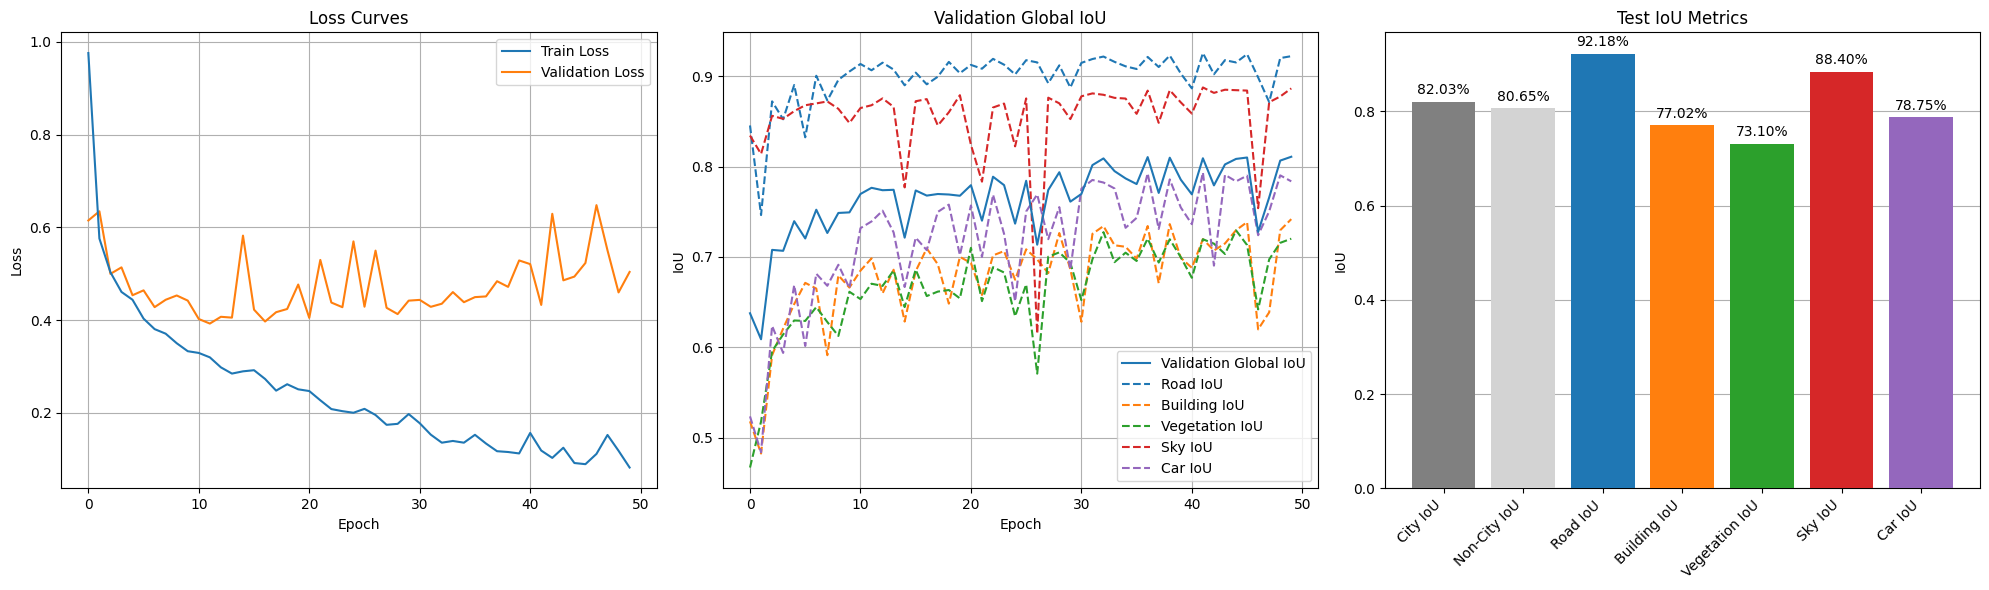


Searching for model weights for run g1mw1zpz...
Found model: unet_overfit_3_g1mw1zpz.pth!
tensor([0, 1, 2, 3, 4])


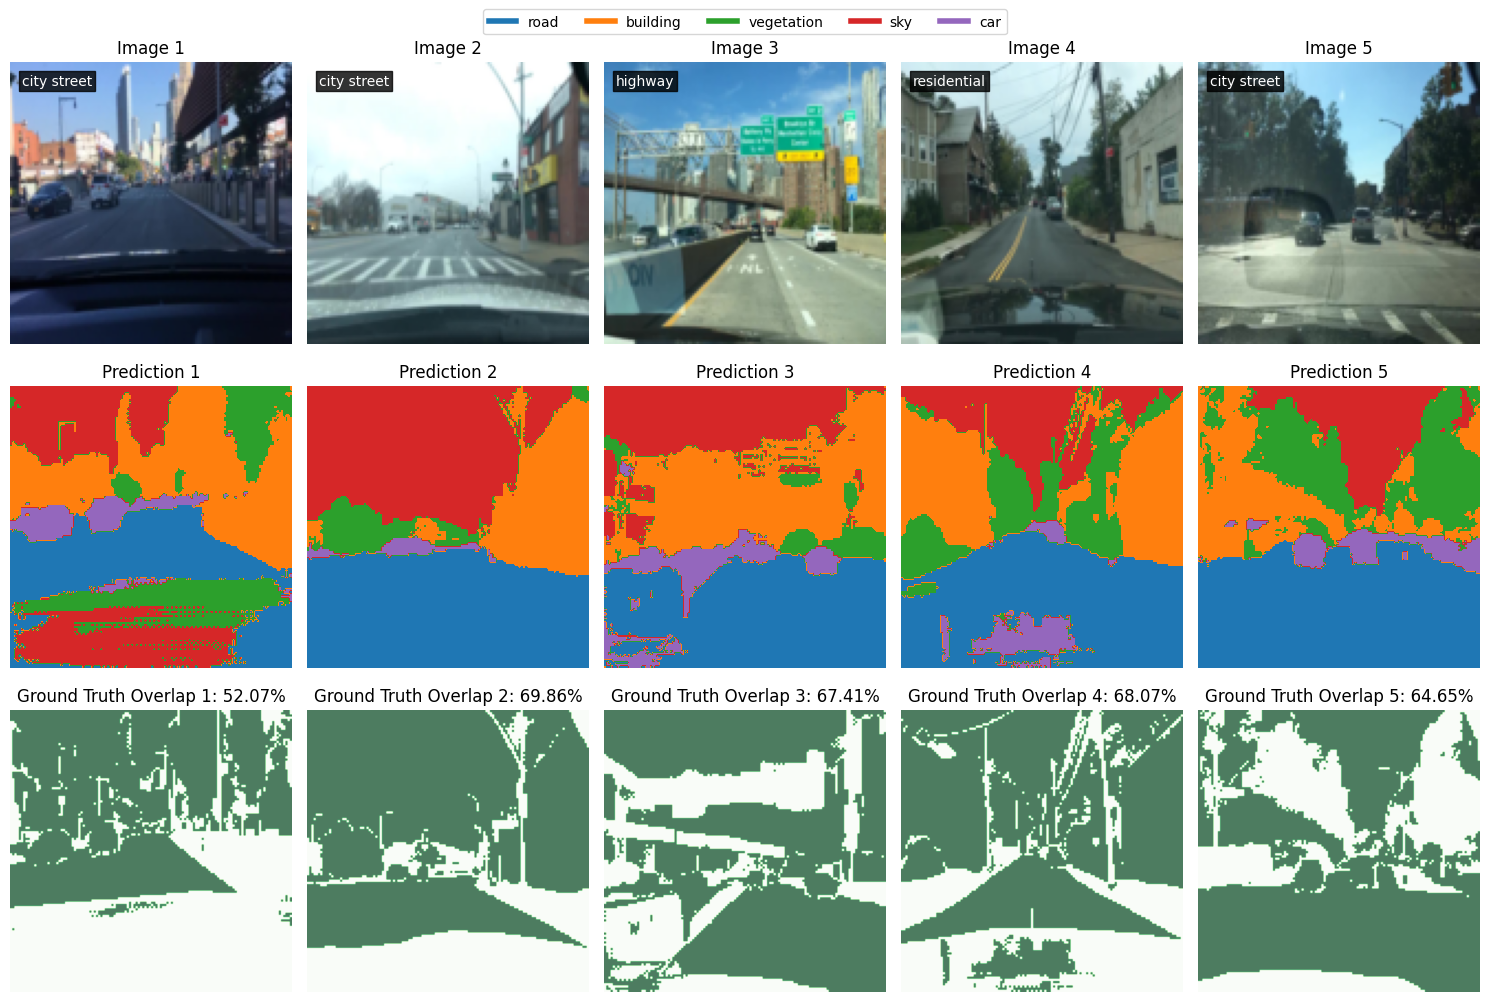

In [17]:
from core import VanillaUNet, AttentionUNet

analyzer = Analyzer(VanillaUNet(num_classes=5, base_filters=128))

analyzer.plot('g1mw1zpz')
analyzer.sample('g1mw1zpz', [test_dataset[0], test_dataset[1], test_dataset[2], test_dataset[3], test_dataset[4]])


/var/folders/th/yt_529gn5qj62429rgx8mqzc0000gn/T/ipykernel_25692/1609168223.py:111: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(test_labels, rotation=45, ha='right')


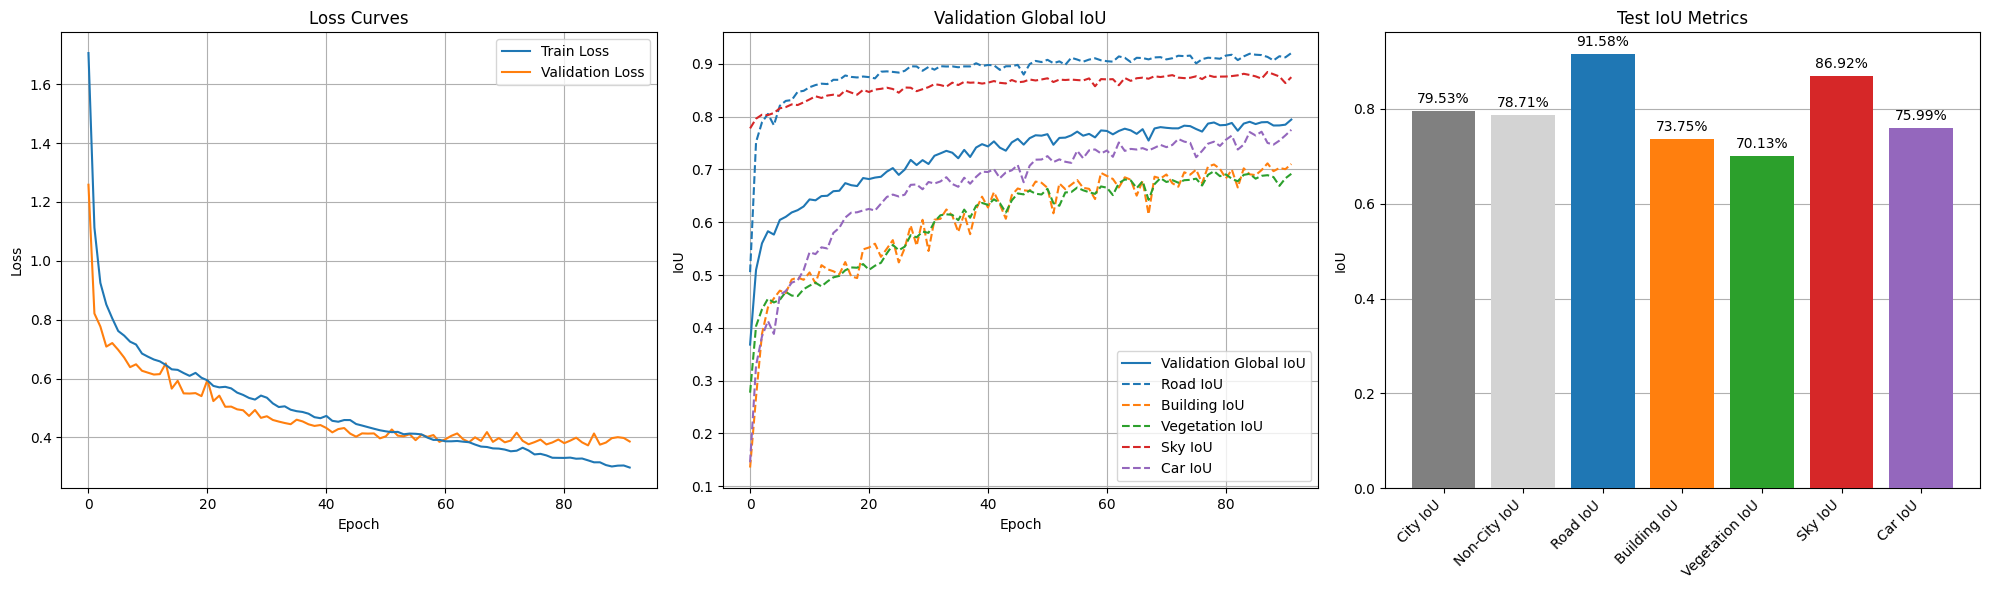


Searching for model weights for run s709aw35...
Found model: unet_attn_dropout_0.2_s709aw35.pth!
tensor([0, 1, 2, 3, 4])


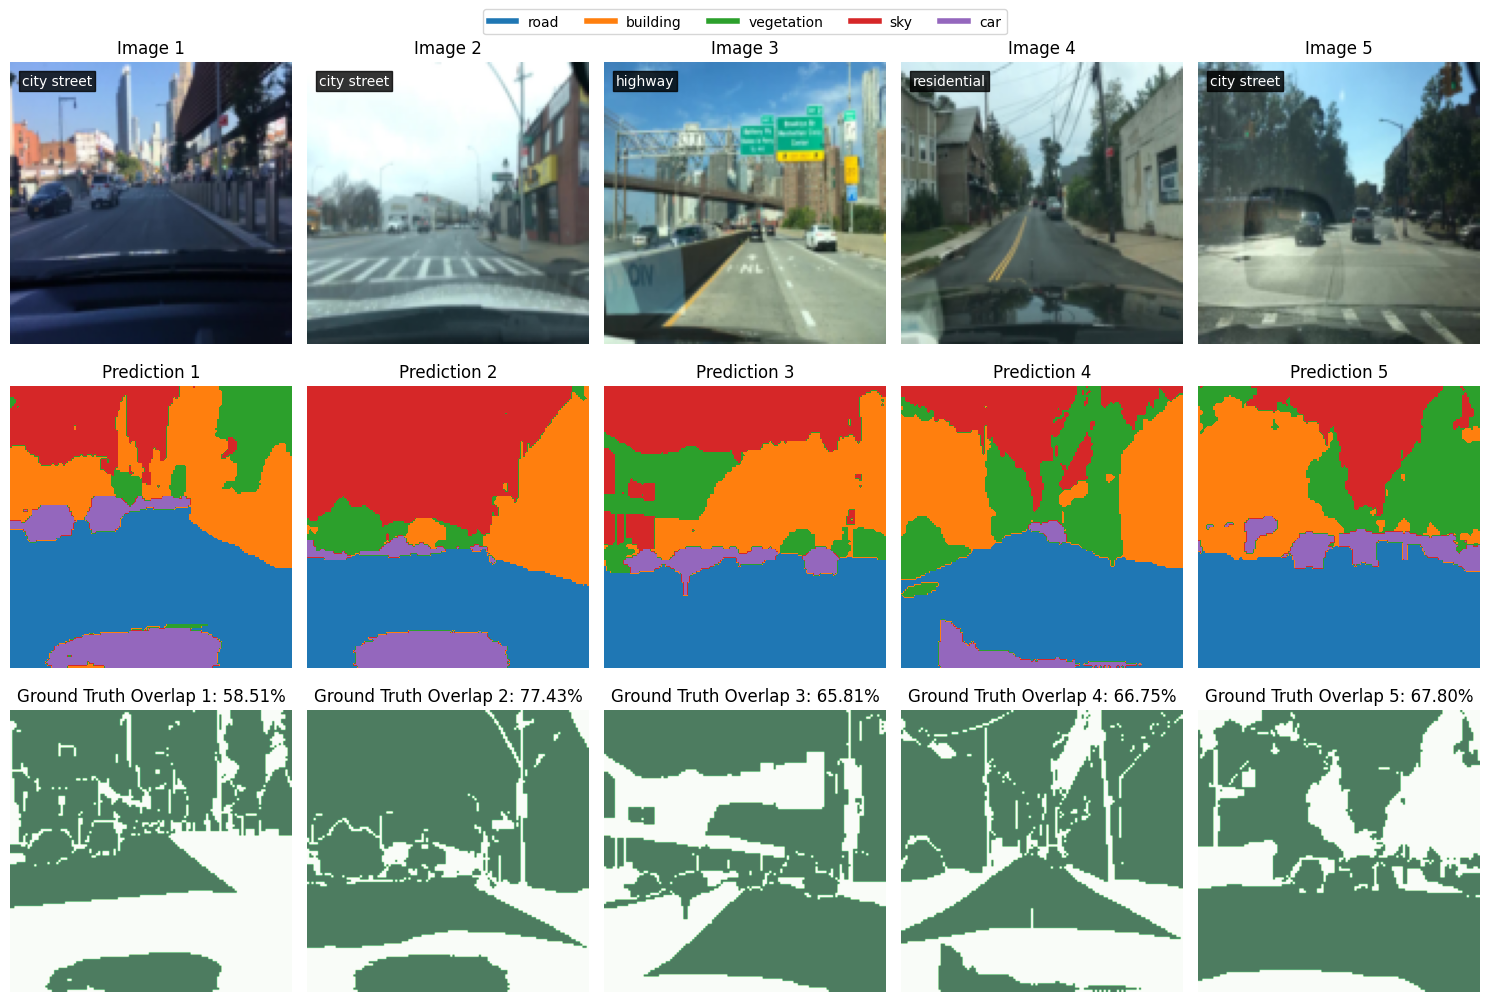

In [16]:
from core import VanillaUNet, AttentionUNet

analyzer = Analyzer(AttentionUNet(num_classes=5, base_filters=64, dropout_prob=0.2))

analyzer.plot('s709aw35')
analyzer.sample('s709aw35', [test_dataset[0], test_dataset[1], test_dataset[2], test_dataset[3], test_dataset[4]])
#Analyzer(run_id="6zef8gfm", project_name="dlbs", entity_name="okaynils", test_dataset=test_dataset, model=VanillaUNet(num_classes=19, base_filters=128))._test_n_samples([1,2])

In [104]:
for i, (image, mask, scene) in enumerate(test_dataset[:100]):
    print(i, scene)

0 highway
1 residential
2 city street
3 residential
4 highway
5 city street
6 highway
7 residential
8 city street
9 city street
10 highway
11 city street
12 city street
13 city street
14 city street
15 city street
16 highway
17 city street
18 highway
19 city street
20 residential
21 residential
22 highway
23 highway
24 residential
25 city street
26 parking lot
27 city street
28 residential
29 residential
30 residential
31 city street
32 city street
33 residential
34 residential
35 city street
36 city street
37 city street
38 city street
39 city street
40 city street
41 city street
42 city street
43 city street
44 residential
45 city street
46 city street
47 highway
48 city street
49 city street
50 highway
51 highway
52 city street
53 highway
54 highway
55 highway
56 highway
57 residential
58 highway
59 city street
60 residential
61 city street
62 city street
63 city street
64 city street
65 residential
66 residential
67 city street
68 residential
69 city street
70 undefined
71 city str


Searching for model weights for run g1mw1zpz...
Found model: unet_overfit_3_g1mw1zpz.pth!
tensor([0, 1, 2, 3, 4])


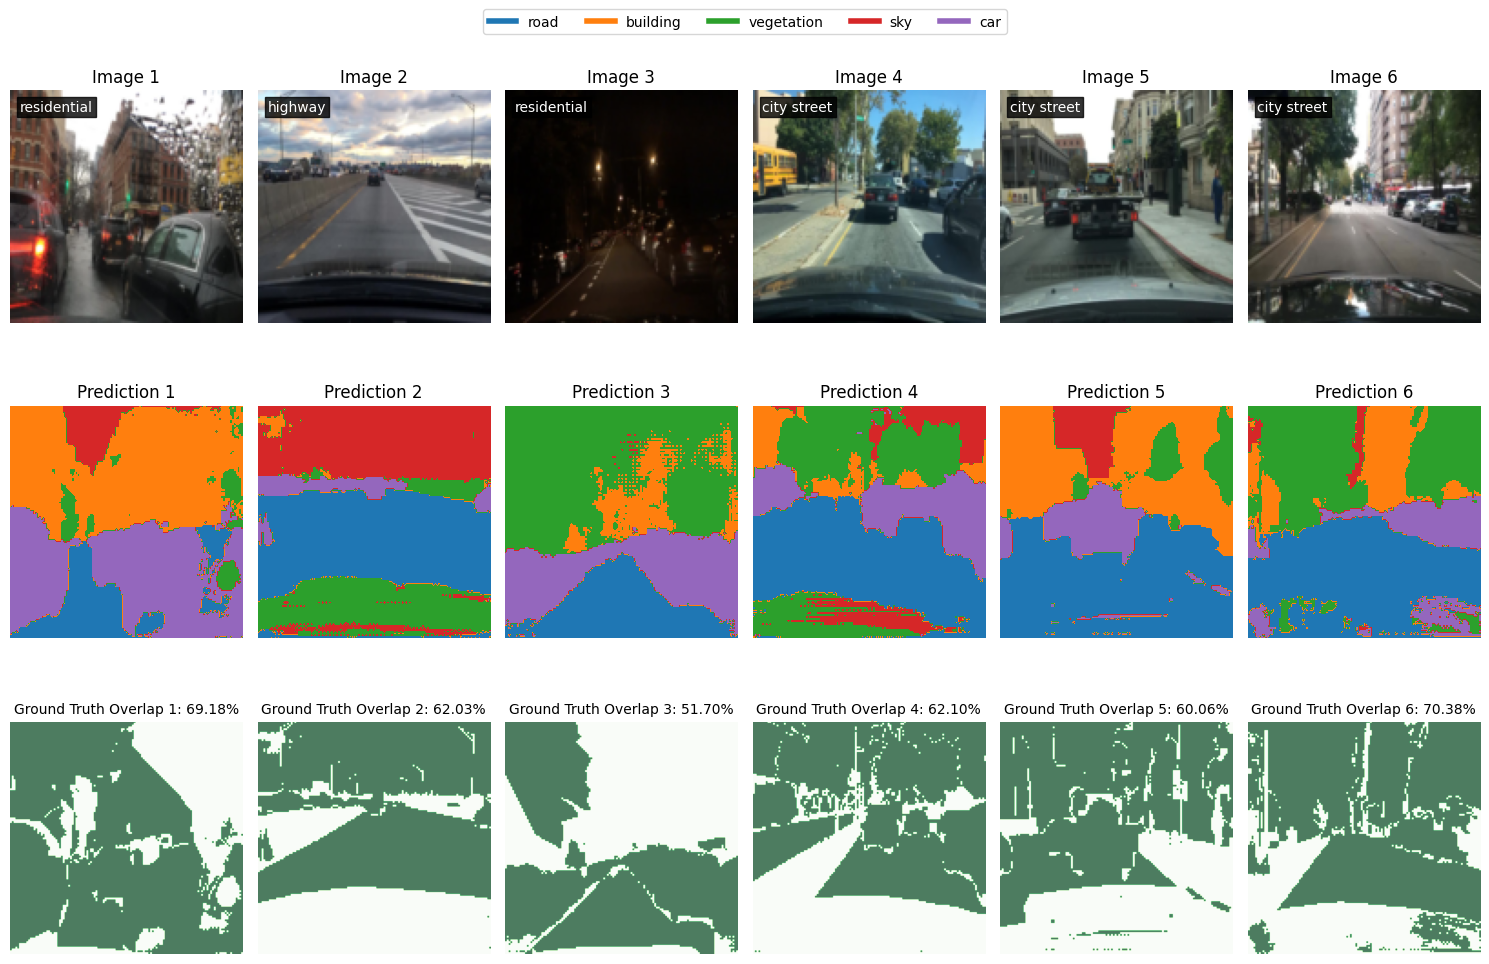

In [105]:
analyzer.sample('g1mw1zpz', [test_dataset[20], test_dataset[0], test_dataset[1], test_dataset[2], test_dataset[14], test_dataset[49]])

tensor([0, 1, 2, 3, 4])

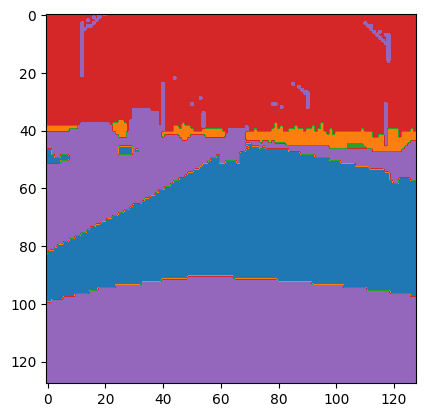

In [67]:
remapping_transform = RemapClasses(old_to_new={0: 0,
                                                           2: 1,
                                                           8: 2,
                                                           10: 3,
                                                           13: 4})
ground_truth = remapping_transform(test_dataset[0][1])

ground_truth[ground_truth == 255] = 4

colors = list(mcolors.TABLEAU_COLORS.values())
class_colors = {i: colors[i % len(colors)] for i in range(5)} 

cmap = mcolors.ListedColormap([class_colors[i] for i in range(5)])

plt.imshow(ground_truth, cmap=cmap)

torch.unique(ground_truth)

In [89]:
from core import UNetBaseline
from core import VanillaUNet
import torch

device="mps"

# load model
model = VanillaUNet(num_classes=5, base_filters=64).to(device)
model.load_state_dict(torch.load('models/unet_overfit_1_9ij91t4w.pth', map_location=torch.device('mps')))

/var/folders/th/yt_529gn5qj62429rgx8mqzc0000gn/T/ipykernel_32027/2066123542.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/unet

<All keys matched successfully>

In [91]:
import hydra 
from torchvision import transforms
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3654, 0.4002, 0.4055],std=[0.2526, 0.2644, 0.2755])
])
image_path = os.path.join(os.path.join('data', 'bdd100k', 'images', '10k', 'test'), 'b0e45326-00000000.jpg')
image = Image.open(image_path)

image_tensor = image_transform(image).unsqueeze(0).to(torch.float).to(device)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4839518..2.388074].


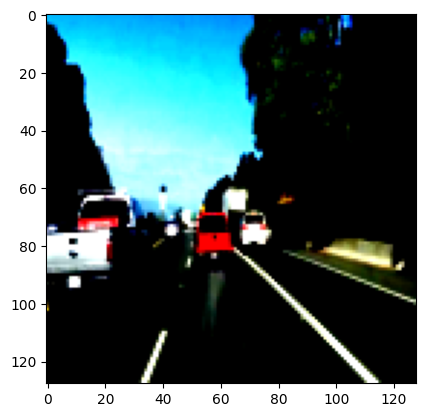

In [92]:
plt.imshow(image_tensor.squeeze(0).permute(1,2,0).cpu())

In [22]:
# predict
model.eval()
with torch.no_grad():
    output = model(image_tensor)

output = output.argmax(1).squeeze().cpu().numpy()

# create a mask image
mask_image = Image.fromarray(output.astype(np.uint8))

import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot original image
axs[0].imshow(image_tensor.squeeze(0).permute(1,2,0).cpu())
axs[0].axis('off')
axs[0].set_title('Original Image')

# Plot mask image
axs[1].imshow(mask_image, cmap='tab20')
axs[1].axis('off')
axs[1].set_title('Predicted Mask')

plt.show()

# Print unique values and their class names
print("Unique values in mask:", np.unique(output))

NameError: name 'model' is not defined

### Regularization

[Regularize](https://karpathy.github.io/2019/04/25/recipe/#:~:text=4.-,Regularize,-Ideally%2C%20we%20are)

### Tuning the model

[Tune](https://karpathy.github.io/2019/04/25/recipe/#:~:text=5.-,Tune,-You%20should%20now)

### Ensembles & Leave it training

[Squeeze out the juice](https://karpathy.github.io/2019/04/25/recipe/#:~:text=Squeeze%20out%20the%20juice)